##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 音频数据准备和增强

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/io/tutorials/audio"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/io/tutorials/audio.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/io/tutorials/audio.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
      <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/io/tutorials/audio.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

## 概述

自动语音识别面临的最大挑战之一是音频数据的准备和增强。音频数据分析可能涉及时域或频域，与图像等其他数据源相比，这提高了复杂性。

作为 TensorFlow 生态系统的一部分，`tensorflow-io` 软件包提供了不少与音频相关的 API。这些 API 非常有用，可简化音频数据的准备和增强。

## 设置

### 安装要求的软件包，然后重新启动运行时

In [2]:
!pip install tensorflow-io

     |▍                               | 286 kB 3.7 MB/s eta 0:00:07

     |█████▍                          | 3.8 MB 3.7 MB/s eta 0:00:06

     |██████████████▌                 | 10.3 MB 3.7 MB/s eta 0:00:04

     |███████████████████████▋        | 16.7 MB 3.7 MB/s eta 0:00:02

     |████████████████████████████████| 22.7 MB 3.7 MB/s eta 0:00:01

     |████████████████████████████████| 22.7 MB 3.7 MB/s 


     |████████████████████████████████| 2.3 MB 91.6 MB/s 


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


## 使用方法

### 读取音频文件

在 TensorFlow IO 中，利用类 `tfio.audio.AudioIOTensor` 可以将音频文件读取到延迟加载的 `IOTensor` 中：

In [3]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

2021-08-13 21:06:31.371935: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-08-13 21:06:31.372324: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


2021-08-13 21:06:32.108629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-13 21:06:32.115449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-13 21:06:32.116341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-13 21:06:32.118294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


在上面的示例中，Flac 文件 `brooklyn.flac` 来自 [Google Cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud) 中可公开访问的音频片段。

示例中直接使用 GCS 地址 `gs://cloud-samples-tests/speech/brooklyn.flac`，因为 TensorFlow 支持 GCS 文件系统。除了 `Flac` 格式，凭借自动文件格式检测，`AudioIOTensor` 还支持 `WAV`、`Ogg`、`MP3` 和 `MP4A` 格式。

`AudioIOTensor` 是一个延迟加载张量，因此，刚开始只显示形状、dtype 和采样率。`AudioIOTensor` 的形状用 `[samples, channels]` 表示，这表示您加载的音频片段是单声道音频（`int16` 类型的 `28979` 个样本）。

仅需要时才会读取该音频片段的内容。要读取音频片段的内容，可通过 `to_tensor()` 将 `AudioIOTensor` 转换为 `Tensor`，也可以通过切片读取。如果只需要一个大音频片段的一小部分，切片尤其实用：

In [4]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


音频可通过以下方式播放：

In [5]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

更方便的方式是，将张量转换为浮点数并在计算图中显示音频片段：

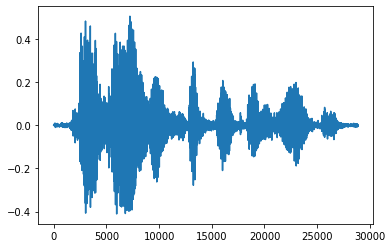

In [6]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

### 降噪

为音频降噪有时很有意义，这可以通过 API `tfio.audio.trim` 实现。从该 API 返回的是片段的一对 `[start, stop]` 位置：

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


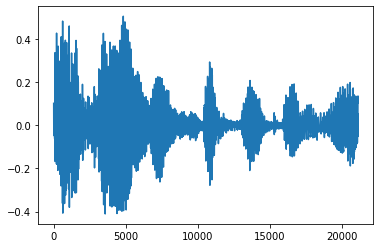

In [7]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### 淡入和淡出

一种有用的音频工程技术是淡入淡出，也就是逐渐增强或减弱音频信号。这可以通过 `tfio.audio.fade` 实现。`tfio.audio.fade` 支持不同的淡入淡出形状，如 `linear`、`logarithmic` 或 `exponential`：

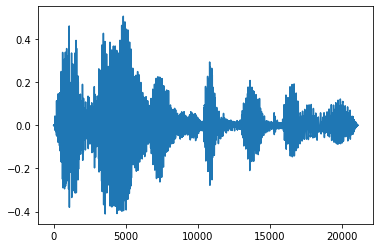

In [8]:
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

### 声谱图

高级音频处理通常需要根据时间调整音频频率。在 `tensorflow-io` 中，可通过 `tfio.audio.spectrogram` 将波形图转换为声谱图。

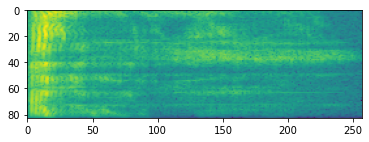

In [9]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

也可以转换为其他不同的比例：

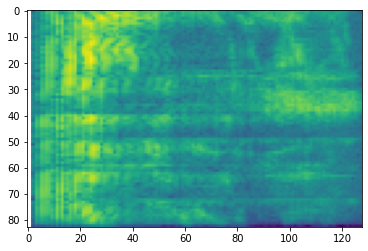

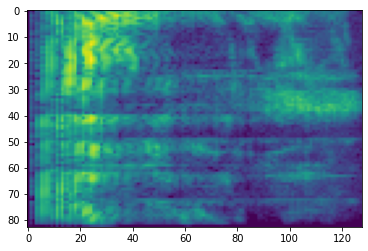

In [10]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

除上述数据准备和增强 API 外，`tensorflow-io` 软件包还提供了高级声谱图增强，最主要的是在 [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019)](https://arxiv.org/pdf/1904.08779.pdf) 中讨论的频率掩蔽和时间掩蔽。

#### 频率掩蔽

在频率掩蔽中，对频率通道 `[f0, f0 + f)` 进行掩蔽，其中 `f` 选自从 `0` 到频率掩蔽参数 `F` 的均匀分布，而 `f0` 则选自 `(0, ν − f)`，其中 `ν` 是频率通道的数量。

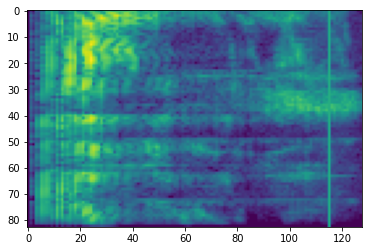

In [11]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

#### 时间掩蔽

在时间掩蔽中，对 `t` 个连续时间步骤 `[t0, t0 + t)` 进行掩蔽，其中 `t` 选自从 `0` 到时间掩蔽参数 `T` 的均匀分布，而 `t0` 则选自 `[0, τ − t)`，其中 `τ` 是时间步数。

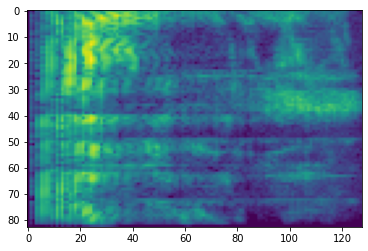

In [12]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy())